In [4]:
# imports and settings
%run plot_settings.py
%matplotlib inline

from scipy import signal

# import DataAnalysisFunctions as daf

# load experimental data
path_ind = '/Users/stephan/Desktop/GitHub/gene_transcription_SMC_ABC/experimental_data/'
data_ind_10pM = np.loadtxt(path_ind+'data_ind_10pM.csv')
data_ind_1000pM = np.loadtxt(path_ind+'data_ind_1000pM.csv')

mock_ind_10pM = np.loadtxt(path_ind+'mock_ind_10pM.csv')
mock_ind_1000pM = np.loadtxt(path_ind+'mock_ind_1000pM.csv')

# load simulations
path_sim = '/Users/stephan/Desktop/GitHub/gene_transcription_SMC_ABC/simulations/'
sim_115_10pM = np.loadtxt(path_sim+'fig4_sim_115_10pM.csv')
sim_115_1000pM = np.loadtxt(path_sim+'fig4_sim_115_1000pM.csv')
sim_195_1000pM = np.loadtxt(path_sim+'fig4_supp_sim_195.csv')

time_ind = np.arange(0,data_ind_10pM.shape[0])*1.5

# Experimental response time, Fig 4 A & B

In [5]:
def extract_response_simple_thresholding(data,time,window,threshold,plot = False):
    data_median = signal.medfilt(data,window)
    
    on = data_median >= threshold
    on = sp.ndimage.binary_opening(on, structure=np.ones(5,)).astype(np.int)
    
    ind = np.where(on == 1)[0]
    
    if len(ind) > 0:
        ind = ind[0]
        
        if ind == 0:
            reaction_time = 0.0
        else:
            x1 = time[ind - 1].astype(np.float)
            x2 = time[ind].astype(np.float)
            y1 = data_median[ind - 1].astype(np.float)
            y2 = data_median[ind].astype(np.float)

            a = (y2 - y1)/(x2 - x1)

            b = y1 - a*x1

            reaction_time = (threshold - b)/a
    
    else:
        reaction_time = time[-1]
        
    if plot == True:
        fig,ax = pl.subplots(1,1, figsize= (30,10))
        xmin,xmax = 0,300

        ax.plot(time,data, lw = 4)
        ax.plot(time,data_median,lw = 4)
        ax.plot([0,750],[0,0],lw = 2)
        ax.plot([0,750],[threshold,threshold],lw = 2)
        ax.plot([reaction_time,reaction_time],[0,10],lw = 4)
        ax.set_xlim(xmin,xmax)
        
    return reaction_time

def extract_response_multi(data,time,window,threshold):
    resp_t = np.zeros(data.shape[1])
    for ii in np.arange(0,data.shape[1]):
        resp_t[ii] = extract_response_simple_thresholding(data[:,ii],time,window=window,threshold=threshold)
        
    return resp_t

In [6]:
# define filter parameters
window = 7
threshold = 2
induction_index = 34
scale = 23.3

#extract response times and sort data
resp_t_10 = extract_response_multi(data_ind_10pM[induction_index:,:]/scale,
                                   time_ind[0:-induction_index],window = window,threshold = threshold)
ind_sort_10 = np.argsort(resp_t_10)
data_ind_10_sorted = data_ind_10pM[:,ind_sort_10]/scale

resp_t_1000 = extract_response_multi(data_ind_1000pM[induction_index:,:]/scale,
                                   time_ind[0:-induction_index],window = window,threshold = threshold)
ind_sort_1000 = np.argsort(resp_t_1000)
data_ind_1000_sorted = data_ind_1000pM[:,ind_sort_1000]/scale

# simulations
resp_t_sim_10 = extract_response_multi(sim_115_10pM[induction_index:,:],
                                   time_ind[0:-induction_index],window = window,threshold = threshold)
ind_sort_10 = np.argsort(resp_t_sim_10)
sim_115_10_sorted = sim_115_10pM[:,ind_sort_10]

resp_t_sim_1000 = extract_response_multi(sim_115_1000pM[induction_index:,:],
                                   time_ind[0:-induction_index],window = window,threshold = threshold)
ind_sort_1000 = np.argsort(resp_t_sim_1000)
sim_115_1000_sorted = sim_115_1000pM[:,ind_sort_1000]



In [7]:
def fig4_induction(Data_ind_10_sorted, Data_ind_1000_sorted,resp_t_10,resp_t_1000, Sim_ind_10, Sim_ind_1000,
              resp_t_sim_10,resp_t_sim_1000, save = [False]):
    fig = pl.figure(figsize = (17, 17))

    gs = gridspec.GridSpec(15, 23)

    cmap = matplotlib.cm.viridis
    interpolation = 'none'
    aspect = 'auto'
    c_max = 40
    ticks = np.arange(0, 251, 60)

    # data 10 pM
    index = -np.sort(-np.arange(0, 162))
    ax = fig.add_subplot(gs[1:5, 0:11])
    cax = ax.imshow(Data_ind_10_sorted[index, :], interpolation = interpolation, aspect = aspect, cmap = cmap)
    ax.plot(-np.sort(-resp_t_10)/1.5+34,np.arange(0,163),'s',ms = 5, color = 'crimson')
    ax.plot([34, 34], [0, 163], '--', lw = 2, color = 'lightgrey')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 162)
    cax.set_clim(0, c_max)
    ticks = np.arange(0, Data_ind_10_sorted.shape[0] + 1, 50)
    ax.set_xticks(ticks)
    ax.set_xticklabels(np.array(ticks * 1.5, dtype = 'int'))
    ax.set_yticks([])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Cells @ 10 pM')
    cv_t = resp_t_10.std()/resp_t_10.mean()
    ax.set_title('Median response:'+str(np.round(np.median(resp_t_10),1))+'min, CV = '+str(np.round(cv_t,2)))

    # data 1000 pM
    ax = fig.add_subplot(gs[1:5, 12:])
    cax = ax.imshow(Data_ind_1000_sorted[index, :], interpolation = interpolation,
                    aspect = aspect, cmap = cmap)
    ax.plot(-np.sort(-resp_t_1000)/1.5+34,np.arange(0,163),'s',ms = 5, color = 'crimson')
    ax.plot([34, 34], [0, 163], '--', lw = 2, color = 'lightgrey')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 162)
    cax.set_clim(0, c_max)
    ticks = np.arange(0, Data_ind_1000_sorted.shape[0] + 1, 50)
    ax.set_xticks(ticks)
    ax.set_xticklabels(np.array(ticks * 1.5, dtype = 'int'))
    ax.set_yticks([])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Cells @ 1000 pM')
    cv_t = resp_t_1000.std()/resp_t_1000.mean()
    ax.set_title('Median response:'+str(np.round(np.median(resp_t_1000),1))+'min, CV = '+str(np.round(cv_t,2)))

    cbar = fig.add_axes([0.125, 0.87, 0.368, 0.02])
    fig.colorbar(cax, cax = cbar, orientation = "horizontal", ticks = [0, 20, 40])
    cbar.set_xlabel('# RNA', labelpad = -70)

    # 115 simulation, 10 pM
    ax = fig.add_subplot(gs[6:10, 0:11])
    cax = ax.imshow(Sim_ind_10[index, :], interpolation = interpolation, aspect = aspect, cmap = cmap)
    ax.plot(-np.sort(-resp_t_sim_10)/1.5+34,np.arange(0,163),'s',ms = 5, color = 'crimson')
    ax.plot([34, 34], [0, 163], '--', lw = 2, color = 'lightgrey')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 162)
    cax.set_clim(0, c_max)
    ticks = np.arange(0, Data_ind_10_sorted.shape[0] + 1, 50)
    ax.set_xticks(ticks)
    ax.set_xticklabels(np.array(ticks * 1.5, dtype = 'int'))
    ax.set_yticks([])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Simulations @ 10 pM')
    cv_t = resp_t_sim_10.std()/resp_t_sim_10.mean()
    ax.set_title('Median response:'+str(np.round(np.median(resp_t_sim_10),2))+'min, CV = '+str(np.round(cv_t,2)))

    # 11 simulation, 1000 pM
    ax = fig.add_subplot(gs[6:10, 12:])
    cax = ax.imshow(Sim_ind_1000[index, :], interpolation = interpolation, aspect = aspect, cmap = cmap)
    ax.plot(-np.sort(-resp_t_sim_1000)/1.5+34,np.arange(0,163),'s',ms = 5, color = 'crimson')
    ax.plot([34, 34], [0, 163], '--', lw = 2, color = 'lightgrey')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 162)
    cax.set_clim(0, c_max)
    ticks = np.arange(0, Data_ind_10_sorted.shape[0] + 1, 50)
    ax.set_xticks(ticks)
    ax.set_xticklabels(np.array(ticks * 1.5, dtype = 'int'))
    ax.set_yticks([])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Simulations @ 1000 pM')
    cv_t = resp_t_sim_1000.std()/resp_t_sim_1000.mean()
    ax.set_title('Median response:'+str(np.round(np.median(resp_t_sim_1000),1))+'min, CV = '+str(np.round(cv_t,1)))

    if save[0] == True:
        pl.savefig(save[1] + save[2], dpi = save[3])

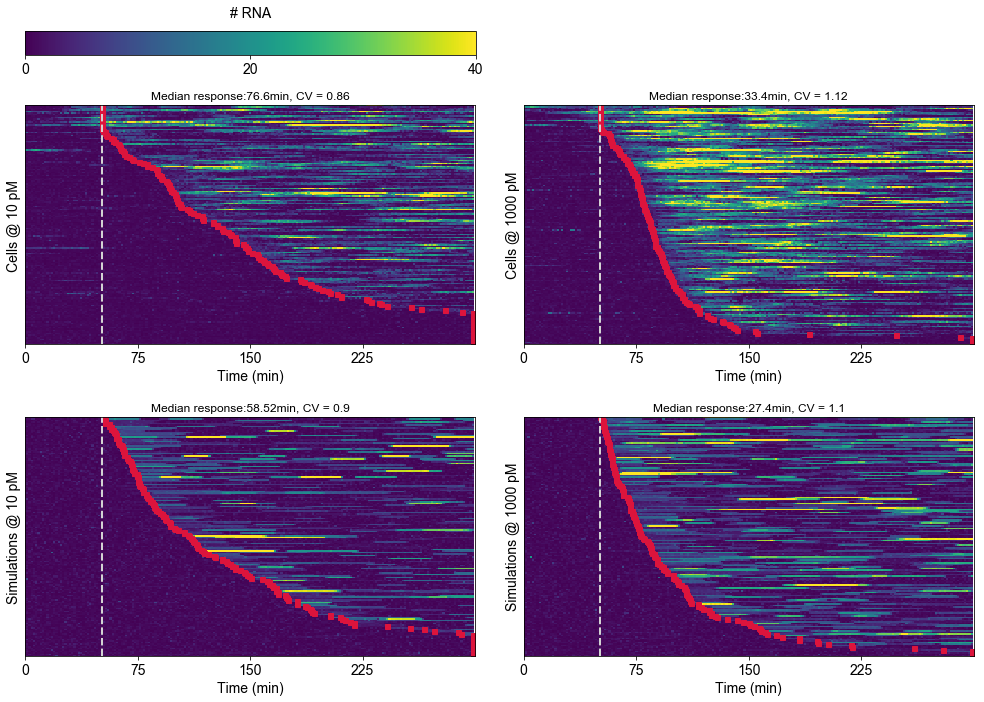

In [8]:
fig4_induction(data_ind_10_sorted.transpose(),data_ind_1000_sorted.transpose(),resp_t_10,resp_t_1000,
               sim_115_10_sorted.transpose(),sim_115_1000_sorted.transpose(),resp_t_sim_10,resp_t_sim_1000)

# Response time of a 10 state system, Fig EV4 D

In [9]:
resp_t_sim_195 = extract_response_multi(sim_195_1000pM[induction_index:,:],
                                   time_ind[0:-induction_index],window = window,threshold = threshold)
ind_sort_1000 = np.argsort(resp_t_sim_195)
sim_195_1000_sorted = sim_195_1000pM[:,ind_sort_1000]

In [10]:
def fig_EV4_simulation195(sim_195_1000_sorted,resp_t_sim_195, save = [False]):
    fig = pl.figure(figsize = (12, 6))

    gs = gridspec.GridSpec(15, 23)

    cmap = matplotlib.cm.viridis
    interpolation = 'none'
    aspect = 'auto'
    c_max = 20
    ticks = np.arange(0, 251, 60)

    # data 10 pM
    index = -np.sort(-np.arange(0, 162))
    ax = fig.add_subplot(gs[:, :])
    cax = ax.imshow(sim_195_1000_sorted[:, index].transpose(), interpolation = interpolation, 
                    aspect = aspect, cmap = cmap)
    ax.plot(-np.sort(-resp_t_sim_195)/1.5+34,np.arange(0,163),'s',ms = 5, color = 'crimson')
    ax.plot([34, 34], [0, 163], '--', lw = 2, color = 'lightgrey')
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 162)
    cax.set_clim(0, c_max)
    ticks = np.arange(0, sim_195_1000_sorted.shape[0] + 1, 50)
    ax.set_xticks(ticks)
    ax.set_xticklabels(np.array(ticks * 1.5, dtype = 'int'))
    ax.set_yticks([])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Cells @ 10 pM')
    cv_t = resp_t_sim_195.std()/resp_t_sim_195.mean()
    ax.set_title('195 model, median respone time: '+str(np.round(np.median(resp_t_sim_195),1))+
                 'min, CV = '+str(np.round(cv_t,2)), fontsize = 17)

    cbar = fig.add_axes([0.125, 0.99, 0.368, 0.05])
    fig.colorbar(cax, cax = cbar, orientation = "horizontal", ticks = [0, 10, 20])
    cbar.set_xlabel('# RNA', labelpad = -55)
    
    if save[0] == True:
        pl.savefig(save[1] + save[2], dpi = save[3])

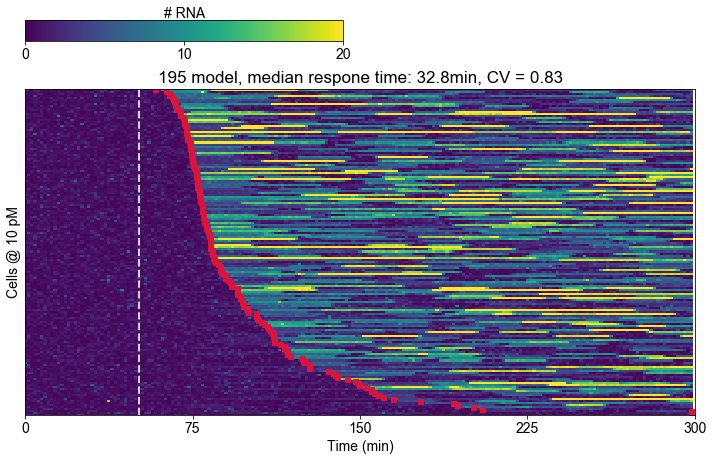

In [11]:
fig_EV4_simulation195(sim_195_1000_sorted,resp_t_sim_195)

# Fitting induction data

In [15]:
path = '/Users/stephan/Desktop/GitHub/gene_transcription_SMC_ABC/model_fits/induction/'
smc_ind_10pM_115 = np.load(path+'smc_ind_10pM_115.npy')
smc_ind_10pM_195 = np.load(path+'smc_ind_10pM_195.npy')
smc_ind_1000pM_115 = np.load(path+'smc_ind_1000pM_115.npy')
smc_ind_1000pM_195 = np.load(path+'smc_ind_1000pM_195.npy')

## Goodness of fit

[Text(0,0,u'10 pM, 115'),
 Text(0,0,u'10 pM, 195'),
 Text(0,0,u'1000 pM,115'),
 Text(0,0,u'1000 pM, 195')]

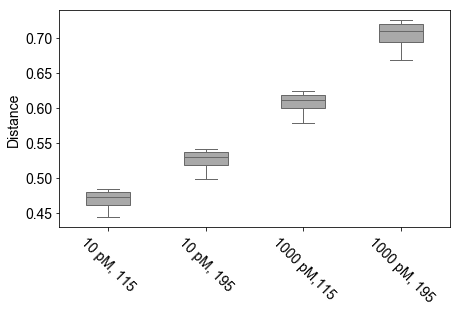

In [18]:
fig,ax = pl.subplots(1,1, figsize = (7,4))

dist = [smc_ind_10pM_115[2][:,-1],smc_ind_10pM_195[2][:,-1],smc_ind_1000pM_115[2][:,-1],smc_ind_1000pM_195[2][:,-1]]
bp = ax.boxplot(dist,patch_artist = True, whis = [5,95],showfliers = False)
nice_boxplots(bp)

ax.set_ylabel('Distance')
ax.set_xticklabels(['10 pM, 115','10 pM, 195','1000 pM,115','1000 pM, 195'],rotation = -45)


## Response time heterogeneity

The box plots generated here are based on a smaller number of simulations. The simulations corresponding to all 1000 posterior particles are too big to deposit here but can be requested if needed.

In [21]:
def extract_response_multi(data,time,window,threshold):
    resp_t = np.zeros(data.shape[1])
    for ii in np.arange(0,data.shape[1]):
        resp_t[ii] = extract_response_simple_thresholding(data[:,ii],time,window=window,threshold=threshold)
        
    return resp_t

def extract_response_multi_particles(sims,time,window,threshold):
    CV = np.zeros(sims.shape[2])
    resp_T = np.zeros((sims.shape[2],sims.shape[1]))
    index = np.arange(0,sims.shape[2])
    for ii in index:
        resp_t = extract_response_multi(sims[:,:,ii],time,window=window,threshold=threshold)
        resp_T[ii] = resp_t
        CV[ii] = resp_t.std()/resp_t.mean()
        
    return CV,resp_T


In [22]:
# bootstrap CV
sel = 0.8
n_samples = 100

CV_10_boot = np.zeros(n_samples)
CV_1000_boot = np.zeros(n_samples)
index = np.arange(0,len(resp_t_10))
for ii in np.arange(0,n_samples):
    sel_size = int(sel*len(resp_t_10))
    sample = np.random.choice(index,sel_size, replace=False)
    mean = resp_t_10[sample].mean()
    std = resp_t_10[sample].std()
    CV_10_boot[ii] = std/mean
    
    mean = resp_t_1000[sample].mean()
    std = resp_t_1000[sample].std()
    CV_1000_boot[ii] = std/mean

In [26]:
CV_115_10,resp_T_115_10 = extract_response_multi_particles(smc_ind_10pM_115[1]/scale,time_ind[0:-induction_index],window=window,threshold=threshold)
CV_195_10,resp_T_195_10 = extract_response_multi_particles(smc_ind_10pM_195[1]/scale,time_ind[0:-induction_index],window=window,threshold=threshold)

CV_115_1000,resp_T_115_1000 = extract_response_multi_particles(smc_ind_1000pM_115[1]/scale,time_ind[0:-induction_index],window=window,threshold=threshold)
CV_195_1000,resp_T_195_1000 = extract_response_multi_particles(smc_ind_1000pM_195[1]/scale,time_ind[0:-induction_index],window=window,threshold=threshold)

0.859790206334


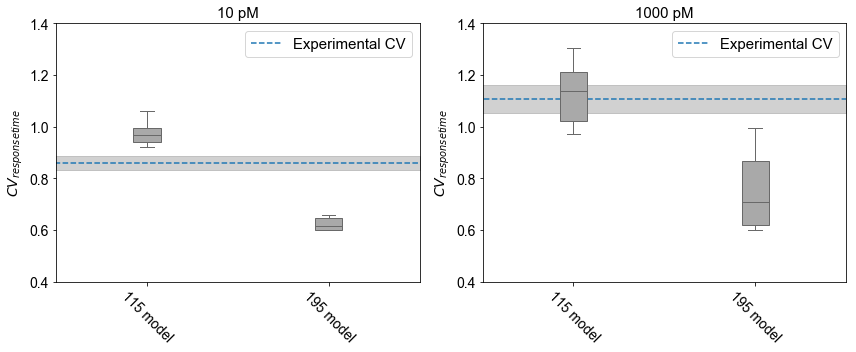

In [27]:
# plot
fig,ax = pl.subplots(1,2, figsize = (12,5))

x = sp.linspace(-0.5,2.5,10)
y = np.zeros(10)+CV_10_boot.mean()
print(CV_10_boot.mean())
high = y + CV_10_boot.std()
low = y - CV_10_boot.std()
ax[0].fill_between(x,high,low,color = 'dimgrey',alpha = 0.3)
ax[0].plot(x,y,'--', label = 'Experimental CV')

CV_10 = [CV_115_10,CV_195_10]
bp = ax[0].boxplot(CV_10,patch_artist=True,whis = [5,95],showfliers = False)
nice_boxplots(bp)
ax[0].legend(fontsize = 15)
ax[0].set_title('10 pM',fontsize=15)
ax[0].set_ylim(0.4,1.4)
ax[0].set_ylabel('$CV_{response time}$')
ax[0].set_xticklabels(['115 model','195 model'],rotation = -45)

y = np.zeros(10)+CV_1000_boot.mean()
high = y + CV_1000_boot.std()
low = y - CV_1000_boot.std()
ax[1].fill_between(x,high,low,color = 'dimgrey',alpha = 0.3)
ax[1].plot(x,y,'--', label = 'Experimental CV')


CV_1000 = [CV_115_1000,CV_195_1000]
bp = ax[1].boxplot(CV_1000,patch_artist=True,whis=[5,95],showfliers=False)
nice_boxplots(bp)
ax[1].legend(fontsize = 15)
ax[1].set_title('1000 pM',fontsize=15)
ax[1].set_ylim(0.4,1.4)
ax[1].set_ylabel('$CV_{response time}$')
ax[1].set_xticklabels(['115 model','195 model'],rotation = -45)

pl.tight_layout()